In [9]:
# install packages and load data

import piplite
await piplite.install(['pandas'])
await piplite.install(['matplotlib'])
await piplite.install(['numpy'])
await piplite.install(['scikit-learn'])
await piplite.install(['scipy'])

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline

In [11]:
from pyodide.http import pyfetch

async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, 'wb') as f:
            f.write(await response.bytes())

In [12]:
# load the Cancer data 

path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv"

In [13]:
await download(path, 'cell_samples.csv')
cell_df = pd.read_csv('cell_samples.csv')
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

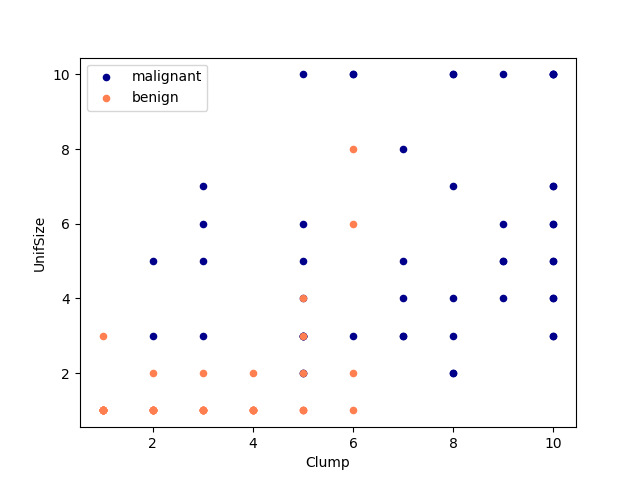

<Figure size 640x480 with 0 Axes>

In [24]:
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind ='scatter',x='Clump', y='UnifSize', color='Darkblue', label ='malignant');
cell_df[cell_df['Class'] == 2][0:50].plot(kind= 'scatter', x='Clump', y='UnifSize', color ='CORAL', label='benign', ax=ax);
plt.show()                             

## Data pre-processing and selection

In [25]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [27]:
# dropping non-numerical columns

cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors = 'coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [29]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

In [31]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y [0:5]

array([2, 2, 2, 2, 2])

# Train and Test Dataset

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 4)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


### Modeling with sklearn and SVM

In [33]:
from sklearn import svm 
clf = svm.SVC(kernel = 'rbf')
clf.fit(X_train, y_train)

SVC()

In [34]:
# when fitted it can be used to predict new values

yhat = clf.predict(X_test)
yhat [0:5]

array([2, 4, 2, 4, 2])

In [35]:
# Evaluation

from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


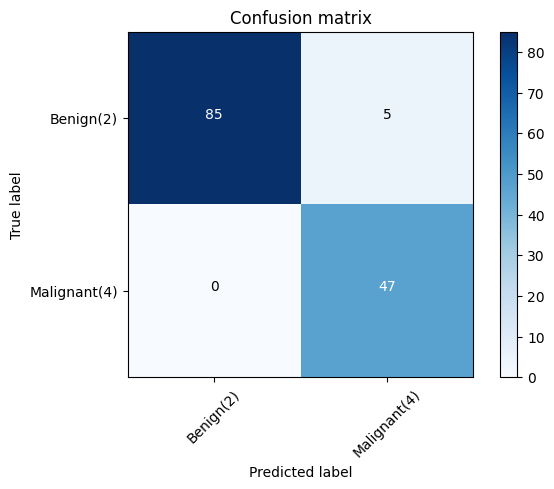

In [37]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

In [38]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average ='weighted')

0.9639038982104676

In [41]:
# using the jaccard index score

from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label=2)

0.9444444444444444

Can you rebuild the model, but this time with a __linear__ kernel? You can use __kernel='linear'__ option, when you define the svm. How the accuracy changes with the new kernel function?

In [55]:
from sklearn import svm 
clf2 = svm.SVC(kernel = 'linear')
clf2.fit(X_train, y_train)

yhat2 = clf2.predict(X_test)
yhat2[0:5]

array([2, 4, 2, 4, 2])

In [56]:
jaccard_score(y_test, yhat2,pos_label=2)

0.9444444444444444

In [57]:
f1_score(y_test, yhat2, average='weighted')

0.9639038982104676